# - Credict risk scoring - Proyect

In [1]:
__author__ = "Jorge Aliaga Luque"
__website__ = "https://jorgealiaga36.github.io/jorge-aliaga-luque/"

The main goal of this proyect is to apply machine learning to predict whether a customer will fail to pay back a loan (default prediction).

Imagine that we work at a bank. When we receive a loan application, we need to make sure that if we give the money, the customer will be able to pay it back. Every application carries a risk of default — the failure to return the money. We’d like to minimize this risk: before agreeing to give a loan, we want to score the customer and assess the chances of default. If it’s too high, we reject the application. This process is called “credit risk scoring.

We will study different models and we will select the best one for our proyect.

## Table of Contents

- [**1. Reading and preparing data**](#ap1)


- [**2. Exploratory data analysis**](#ap2)

    - 2.1. [Missing values](#ap2_1)
    - 2.2. [Target variable](#ap2_2)
    
 
- [**3. Data preprocessing and feature engineering**](#ap3)

    - 3.1. [Feature scaling](#ap3_1)
    - 3.2. [One-hot encoding](#ap3_2)
        
    
- [**4. Model fitting and selection**](#ap4)

    - 4.1. [Logistic Regression](#ap4_1)
    - 4.2. [Decision Trees](#ap4_2)
    - 4.3. [Random Forest](#ap4_3)
    - 4.4. [SVM](#ap4_4)
    - 4.5. [XGBoost](#ap4_5)
        

- [**5. Comparison between models**](#ap5)

### Import libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

sns.set_style('darkgrid')

<a name="ap1"></a>
# 1. Reading and preparing data

### Load data

In [4]:
df = pd.read_csv("datasets/CreditScoring.csv")

print("Number of examples: {}".format(len(df)))
df.head()

Number of examples: 4455


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


### Data preparation

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


First, we can write columns indexes into lower case:

In [6]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Although most of the columns are numerical, some are categorical: status, home, marital [status], records, and job. The values we see in the DataFrame, however, are numbers, not strings. This means that we need to translate them to their actual names.

In [7]:
status_values = {
     1: 'ok',
     2: 'default',
     0: 'unk'
 }

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}


df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


We must remove these 'unk' values to avoid an issue while training our model.

In [9]:
for var in df.select_dtypes(include='object'):
    df = df[df[var] != 'unk']

For our target variable it is better to have a binary output:

In [10]:
df['status'] = df['status'].map({'default': 1, 'ok': 0})

One thing we notice immediately is that the max value is 99999999 in some cases. As it turns out, it’s an artificial value. This is how missing values
are encoded in this dataset.

In [11]:
df.describe().round()

,status,seniority,time,age,expenses,income,assets,debt,amount,price
count,4446.0,4446.0,4446.0,4446.0,4446.0,4446.0,4446.0,4446.0,4446.0,4446.0
mean,0.0,8.0,46.0,37.0,56.0,697386.0,927532.0,270248.0,1039.0,1462.0
std,0.0,8.0,15.0,11.0,20.0,8321948.0,9559190.0,5188793.0,475.0,629.0
min,0.0,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,0.0,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1116.0
50%,0.0,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,1.0,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,1.0,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [12]:
for column in ['income', 'assets', 'debt']:
    df[column] = df[column].replace(to_replace=99999999.0, value=np.nan)

In [13]:
df.describe().round()

,status,seniority,time,age,expenses,income,assets,debt,amount,price
count,4446.0,4446.0,4446.0,4446.0,4446.0,4415.0,4405.0,4434.0,4446.0,4446.0
mean,0.0,8.0,46.0,37.0,56.0,131.0,5404.0,343.0,1039.0,1462.0
std,0.0,8.0,15.0,11.0,20.0,86.0,11577.0,1246.0,475.0,629.0
min,0.0,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,0.0,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1116.0
50%,0.0,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,1.0,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,1.0,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


### Describe data

In [14]:
#We exclude the target variable.

catCols = list(df.select_dtypes(include='object').columns)
print('There are {} categorical variables: \n{}'.format(len(catCols), catCols))

There are 4 categorical variables: 
['home', 'marital', 'records', 'job']


In [15]:
numCols = list(df.select_dtypes(exclude = 'object').columns[1:]) 
print('There are {} numerical variables: \n{}'.format(len(numCols), numCols))

There are 9 numerical variables: 
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


<a name="ap2"></a>
# 2. Exploratory data analysis

<a name="ap2_1"></a>
## 2.1. Missing values

Now, let´s check for missing values:

In [16]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       31
assets       41
debt         12
amount        0
price         0
dtype: int64

Now, we should check what is the proportion of misssing values in our dataset.
+ As we can see the proportion is very small so it better to remove these observations from the dataset.

In [17]:
percent_df = round(df.isnull().sum()*100/len(df),2)
percent_df

status       0.00
seniority    0.00
home         0.00
time         0.00
age          0.00
marital      0.00
records      0.00
job          0.00
expenses     0.00
income       0.70
assets       0.92
debt         0.27
amount       0.00
price        0.00
dtype: float64

In [18]:
df = df.dropna()

<a name="ap2_2"></a>
## 2.2. Target variable

+ As we can see the mayority of the customers did not fail to pay back the money.
+ We have an imbalanced dataset, there are three times as many people who did not fail to pay back the money as those who did.

In [19]:
global_mean = round(df['status'].mean(), 2)
print("Default rate: {}".format(global_mean))

Default rate: 0.28


0    3159
1    1216
Name: status, dtype: int64

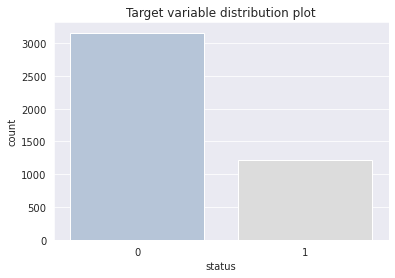

In [20]:
plt.figure(figsize=(6,4))

sns.countplot(data = df, x='status', palette=['#B0C4DE','#DCDCDC'])
plt.title('Target variable distribution plot')

df.status.value_counts()

<a name="ap3"></a>
# 3. Data Preprocessing and Feature engineering

First we split our dataframe into X and y variables to avoid using our target variable in the training process.

In [21]:
X = df.drop(columns=['status'], axis=1)
y = df['status']

<a name="ap3_1"></a>
## 3.1. Feature Scaling

It is highly recommended to scale the numerical features before training the model to achieve a better performance.

In [22]:
scaler = StandardScaler()
X[numCols] = scaler.fit_transform(X[numCols])

<a name="ap3_2"></a>
## 3.2. One-hot Encoding

Now we encode our categorical variables converting them into dummy features:

In [23]:
X = pd.get_dummies(X)

print("X shape: {}\n".format(X.shape))

X shape: (4375, 26)



In [24]:
X.head().T

,0,1,2,3,4
seniority,0.124172,1.103006,0.246526,-0.977016,-0.977016
time,0.922253,0.922253,-0.719602,0.922253,-0.719602
age,-0.639971,1.911996,0.818296,-1.186821,-1.004537
expenses,0.894878,-0.390512,1.768944,0.380722,-0.493343
income,-0.021452,0.001753,0.802313,0.593471,-0.276703
assets,-0.500742,-0.500742,-0.217219,-0.264473,-0.500742
debt,-0.281360,-0.281360,-0.281360,-0.281360,-0.281360
amount,-0.505565,-0.079761,2.049258,-0.292663,-1.548784
price,-0.987176,0.318910,2.453363,-0.216714,-0.884234
home_ignore,0.000000,0.000000,0.000000,0.000000,0.000000


We have all the data prepared. Therefore let's build our models.

<a name="ap4"></a>
# 4. Model fitting and selection

We split our dataset into two parts: train and test sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Functions required 

In [26]:
def tunning_model(model, params):
    
    model_cv = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=5)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']] 
    
    print(cv_results)
    print('\nBest params: {} | Best Roc: {}'.format(model_cv.best_params_,model_cv.best_score_))

In [63]:
def evaluate_model(model, threshold = 0.5):
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    
    #ROC and Accuracy scores.
    
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred>=threshold)
    print('ROC: {}'.format(round(roc_auc,4)))
    print('Accuracy: {}'.format(round(accuracy,4)))
    
    #Plot ROC AUC.
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)

    plt.figure(figsize = (6, 5))

    plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed')

    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    plt.show() 
    
    return fpr, tpr, roc_auc

<a name="ap4_1"></a>
## 4.1. Logistic Regression

In [100]:
params = {'C':[0.01, 0.1, 0.5, 1, 10, 50, 100], 'solver':['liblinear']}

lg = LogisticRegression()
tunning_model(lg, params)

                               params  mean_test_score
0  {'C': 0.01, 'solver': 'liblinear'}         0.835221
1   {'C': 0.1, 'solver': 'liblinear'}         0.839256
2   {'C': 0.5, 'solver': 'liblinear'}         0.839065
3     {'C': 1, 'solver': 'liblinear'}         0.838829
4    {'C': 10, 'solver': 'liblinear'}         0.838557
5    {'C': 50, 'solver': 'liblinear'}         0.838518
6   {'C': 100, 'solver': 'liblinear'}         0.838520

Best params: {'C': 0.1, 'solver': 'liblinear'} | Best Roc: 0.8392559379856201


### Model selected

ROC: 0.8367
Accuracy: 0.7977


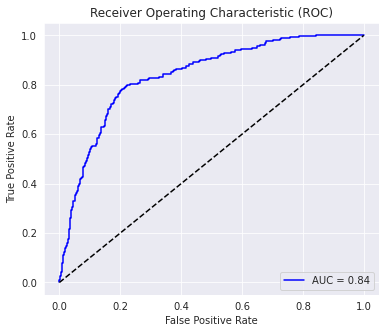

In [64]:
lg = LogisticRegression(C=0.5, solver='liblinear')
fpr_lg, tpr_lg, roc_lg = evaluate_model(lg, threshold=0.5)

<a name="ap4_2"></a>
## 4.2. Decision Trees

In [114]:
params = {'max_depth':[5, 10, 15, 20], 
          'min_samples_leaf': [20, 50, 100, 150, 200]}

dt = DecisionTreeClassifier()
tunning_model(dt, params)

                                        params  mean_test_score
0     {'max_depth': 5, 'min_samples_leaf': 20}         0.777702
1     {'max_depth': 5, 'min_samples_leaf': 50}         0.777987
2    {'max_depth': 5, 'min_samples_leaf': 100}         0.770473
3    {'max_depth': 5, 'min_samples_leaf': 150}         0.770906
4    {'max_depth': 5, 'min_samples_leaf': 200}         0.764147
5    {'max_depth': 10, 'min_samples_leaf': 20}         0.780774
6    {'max_depth': 10, 'min_samples_leaf': 50}         0.795111
7   {'max_depth': 10, 'min_samples_leaf': 100}         0.783188
8   {'max_depth': 10, 'min_samples_leaf': 150}         0.779684
9   {'max_depth': 10, 'min_samples_leaf': 200}         0.768332
10   {'max_depth': 15, 'min_samples_leaf': 20}         0.780212
11   {'max_depth': 15, 'min_samples_leaf': 50}         0.794562
12  {'max_depth': 15, 'min_samples_leaf': 100}         0.783129
13  {'max_depth': 15, 'min_samples_leaf': 150}         0.779684
14  {'max_depth': 15, 'min_samples_leaf'

### Model selected

ROC: 0.807
Accuracy: 0.7703


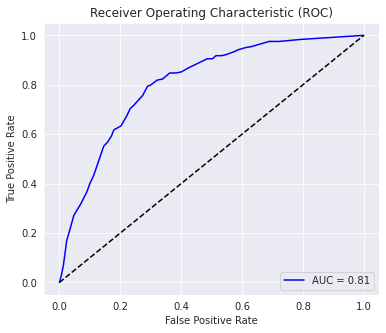

In [65]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=50)
fpr_dt, tpr_dt, roc_dt = evaluate_model(dt, threshold=0.5)

<a name="ap4_3"></a>
## 4.3. Random Forest

In [109]:
params = {'max_depth':[5, 10, 15, 20], 
          'min_samples_leaf': [3, 5, 10],
          'n_estimators': [50, 100, 150, 200]}

rf = RandomForestClassifier()
tunning_model(rf, params)

                                               params  mean_test_score
0   {'max_depth': 5, 'min_samples_leaf': 3, 'n_est...         0.825538
1   {'max_depth': 5, 'min_samples_leaf': 3, 'n_est...         0.828934
2   {'max_depth': 5, 'min_samples_leaf': 3, 'n_est...         0.831463
3   {'max_depth': 5, 'min_samples_leaf': 3, 'n_est...         0.829997
4   {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...         0.828641
5   {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...         0.828418
6   {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...         0.829228
7   {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...         0.829827
8   {'max_depth': 5, 'min_samples_leaf': 10, 'n_es...         0.828801
9   {'max_depth': 5, 'min_samples_leaf': 10, 'n_es...         0.829257
10  {'max_depth': 5, 'min_samples_leaf': 10, 'n_es...         0.827966
11  {'max_depth': 5, 'min_samples_leaf': 10, 'n_es...         0.829460
12  {'max_depth': 10, 'min_samples_leaf': 3, 'n_es...         0.835532
13  {'

### Model selected

ROC: 0.8357
Accuracy: 0.792


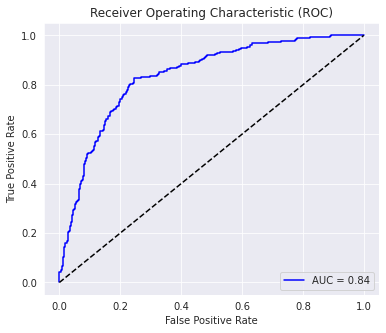

In [66]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200, random_state=2)
fpr_rf, tpr_rf, roc_rf = evaluate_model(rf, threshold=0.5)

<a name="ap4_4"></a>
## 4.4. SVM

In [37]:
params = {'C': [0.1, 1, 10, 100],
          'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC()
tunning_model(svc, params)

                        params  mean_test_score
0       {'C': 0.1, 'gamma': 1}         0.754079
1     {'C': 0.1, 'gamma': 0.1}         0.839645
2    {'C': 0.1, 'gamma': 0.01}         0.840356
3   {'C': 0.1, 'gamma': 0.001}         0.835325
4         {'C': 1, 'gamma': 1}         0.751253
5       {'C': 1, 'gamma': 0.1}         0.839450
6      {'C': 1, 'gamma': 0.01}         0.845908
7     {'C': 1, 'gamma': 0.001}         0.835474
8        {'C': 10, 'gamma': 1}         0.730577
9      {'C': 10, 'gamma': 0.1}         0.817338
10    {'C': 10, 'gamma': 0.01}         0.849618
11   {'C': 10, 'gamma': 0.001}         0.840163
12      {'C': 100, 'gamma': 1}         0.730858
13    {'C': 100, 'gamma': 0.1}         0.767997
14   {'C': 100, 'gamma': 0.01}         0.838964
15  {'C': 100, 'gamma': 0.001}         0.843331

Best params: {'C': 10, 'gamma': 0.01} | Best Roc: 0.8496182318849061


### Model selected

ROC: 0.8294
Accuracy: 0.7909


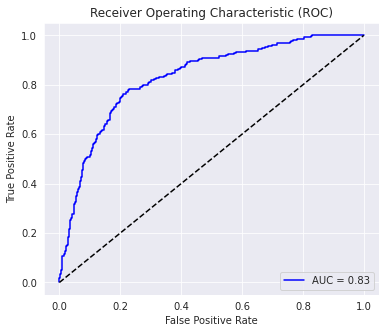

In [67]:
svc = SVC(C=10, gamma=0.01, probability=True, random_state=2)
fpr_svc, tpr_svc, roc_svc = evaluate_model(svc, threshold=0.5)

<a name="ap4_5"></a>
## 4.5. XGBoost

In [58]:
params = {'eta': [0.01, 0.03, 0.05, 0.1],
          'max_depth': [3, 5, 6, 10],
          'objective':['binary:logistic'],
          'min_child_weight': [1, 10, 30],
          'eval_metric': ['auc']}

xgb = XGBClassifier()
tunning_model(xgb, params)

                                               params  mean_test_score
0   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.808375
1   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.808768
2   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.806497
3   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.819599
4   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.819704
5   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.811246
6   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.819916
7   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.821662
8   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.812883
9   {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.812233
10  {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.823229
11  {'eta': 0.01, 'eval_metric': 'auc', 'max_depth...         0.813173
12  {'eta': 0.03, 'eval_metric': 'auc', 'max_depth...         0.835638
13  {'

### Model selected

ROC: 0.8437
Accuracy: 0.8046


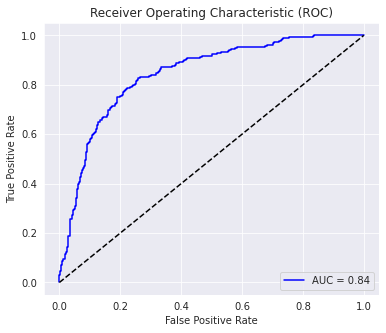

In [68]:
xgb = XGBClassifier(eta=0.1, 
                    max_depth=3,
                    objective='binary:logistic', 
                    min_child_weight=10, 
                    eval_metric='auc')

fpr_xgb, tpr_xgb, roc_xgb = evaluate_model(xgb, threshold=0.5)

<a name="ap5"></a>
# 5. Comparison between models

In [77]:
print('ROC Logistic Regression: {}\n'.format(roc_lg))
print('ROC Decision Trees: {}\n'.format(roc_dt))
print('ROC Random Forest: {}\n'.format(roc_rf))
print('ROC SVM: {}\n'.format(roc_svc))
print('ROC XGB: {}'.format(roc_xgb))

ROC Logistic Regression: 0.8367192790540188

ROC Decision Trees: 0.8069587695994166

ROC Random Forest: 0.8357425639422827

ROC SVM: 0.8294134500182321

ROC XGB: 0.8436539563473461


The results for aour different models are very similiar. Between them we can highlight the Logistic Regression, Random Forest and XGBoost models with a ROC score around 0.83-0.84.

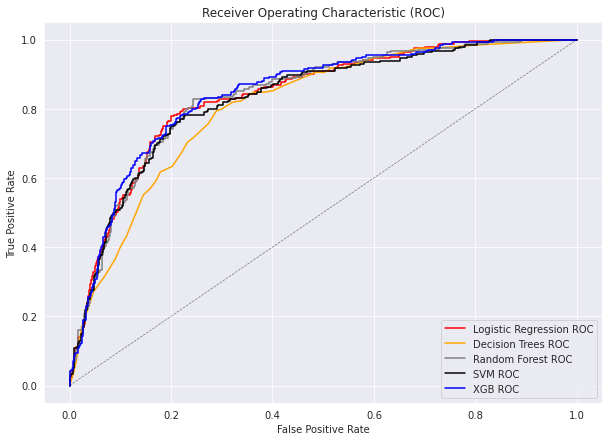

In [87]:
plt.figure(figsize = (10, 7))

plt.plot(fpr_lg, tpr_lg, color='red', linestyle='solid', label='Logistic Regression ROC')
plt.plot(fpr_dt, tpr_dt, color='orange', linestyle='solid', label='Decision Trees ROC')
plt.plot(fpr_rf, tpr_rf, color='grey', linestyle='solid', label='Random Forest ROC')
plt.plot(fpr_svc, tpr_svc, color='black', linestyle='solid', label='SVM ROC')
plt.plot(fpr_xgb, tpr_xgb, color='blue', linestyle='solid', label='XGB ROC')

plt.plot([0, 1], [0, 1], color='black', linewidth=0.7, linestyle='dashed', alpha=0.5)

plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

Therefore we can conclude our best model is the `XGBoost` one with a ROC score ~ 0.84.